# Analyse du jeu de données

## 1. Contruction d'un dataframe récapitulif
La création du DataFrame a pour but de structurer et organiser les données d'images de plantes afin de faciliter l'analyse.

Les données sont organisées de la manière suivante : 

 - Chemin: Enregistrer le chemin complet de chaque image pour pouvoir y accéder facilement.
 - Classe: Identifier la combinaison de la plante et de la maladie/état de santé pour chaque image.
 - Nom_image: Conserver le nom du fichier pour des références futures et des vérifications.
 - Dimensions de l'image: Stocker la largeur et la hauteur des images pour des analyses basées sur les dimensions.
 - Hash MD5: Calculer et stocker le hash MD5 de chaque image pour détecter et gérer les doublons.
 - Format : Format de l'image JPEG,PNG,etc...
 - Mode : Retourne le mode de l'image (RGB,RGBA,L,...)

2 colonnes supplémentaires ont été ajoutées en découpant le champ "Classe" :
 - Plante: Enregistrer le nom de la plante
 - Maladie/Statut : Enregistrer le statut de la plante ( en bonne santé ou avec virus/maladie).


In [4]:
import os
import pandas as pd
import numpy as np
import glob
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import hashlib
import cv2

In [2]:
# Fonction pour calculer le hash d'une image
def calculate_hash(im):
    md5 = hashlib.md5()
    md5.update(np.array(im).tobytes())
    return md5.hexdigest()

In [3]:
# Chemin du répertoire contenant les images
repertoire = r'D:\aprojet\fev24_cds_plants\data\color'

# Liste pour stocker les informations sur les images
donnees = []

In [4]:
# Parcours des sous-répertoires et des fichiers
for dossier, sous_dossiers, fichiers in os.walk(repertoire):
    for nom_fichier in glob.glob(os.path.join(dossier, '*.jpg')):
        chemin_image = nom_fichier
        classe = os.path.basename(dossier)
        nom_image = os.path.basename(nom_fichier)

        try:
            # Lecture de l'image avec Pillow
            image = Image.open(chemin_image)
            largeur, hauteur = image.size
            hash = calculate_hash(image)
            format = image.format
            mode = image.mode

        except Exception as e:
            print(f"Erreur lors de la lecture de l'image {chemin_image}: {e}")
            largeur = None
            hauteur = None

        donnees.append((chemin_image, classe, nom_image, largeur, hauteur, hash, format, mode))

In [5]:
# Création du dataframe
df = pd.DataFrame(donnees, columns=['Chemin', 'Classe', 'Nom_image', 'Largeur', 'Hauteur', 'hash', 'format', 'mode'])
df[['Plante', 'Maladie/Statut']] = df['Classe'].str.split("___", expand=True)

In [6]:
# Sauvegarde du dataframe au format CSV
df.to_csv('dataset_plantdisease.csv', index=False)

In [6]:
# Chargement du dataframe depuis le fichier CSV
df = pd.read_csv('dataset_plantdisease.csv')

In [7]:
# Analyse des données
# 1. Vérification des informations du dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54303 entries, 0 to 54302
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Chemin          54303 non-null  object
 1   Classe          54303 non-null  object
 2   Nom_image       54303 non-null  object
 3   Largeur         54303 non-null  int64 
 4   Hauteur         54303 non-null  int64 
 5   hash            54303 non-null  object
 6   format          54303 non-null  object
 7   mode            54303 non-null  object
 8   Plante          54303 non-null  object
 9   Maladie/Statut  54303 non-null  object
dtypes: int64(2), object(8)
memory usage: 4.1+ MB


## 2. Analyse exploratoire
### 2.1 Distribution des classes
La distribution des classes montre le nombre d'images par espèce de plante et par maladie/statut. Voici les principales observations :
- Les classes les plus représentées sont **Orange avec Haunglongbing (Citrus greening)** et **Tomato avec Tomato Yellow Leaf Curl Virus**, chacune ayant plus de 5000 images.
- Il y a un déséquilibre significatif dans la répartition des images entre les différentes classes, certaines classes ayant beaucoup plus d'images que d'autres.

In [7]:
# Distribution des classes
class_counts = df["Classe"].value_counts().sort_values(ascending=False)
class_counts

Classe
Orange___Haunglongbing_(Citrus_greening)              5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus                5357
Soybean___healthy                                     5090
Peach___Bacterial_spot                                2297
Tomato___Bacterial_spot                               2127
Tomato___Late_blight                                  1908
Squash___Powdery_mildew                               1835
Tomato___Septoria_leaf_spot                           1771
Tomato___Spider_mites Two-spotted_spider_mite         1676
Apple___healthy                                       1645
Tomato___healthy                                      1591
Blueberry___healthy                                   1502
Pepper,_bell___healthy                                1477
Tomato___Target_Spot                                  1404
Grape___Esca_(Black_Measles)                          1383
Corn_(maize)___Common_rust_                           1192
Grape___Black_rot                                

### 2.2 Répartition des plantes

La visualisation en camembert de la répartition des plantes montre la proportion de chaque type de plante dans le dataset. Cela permet de comprendre quelles plantes sont les plus représentées et d'identifier les plantes sous-représentées.

La catégorie la plus représentée est la Tomato (Tomate), représentant 33.44% de l'ensemble des images.

D'autres plantes sont sous-représentées comme Squash, Strawberry, Blueberry ou bien Raspberry (Framboise) qui est la classe la moins représentée, avec seulement 0.68%.

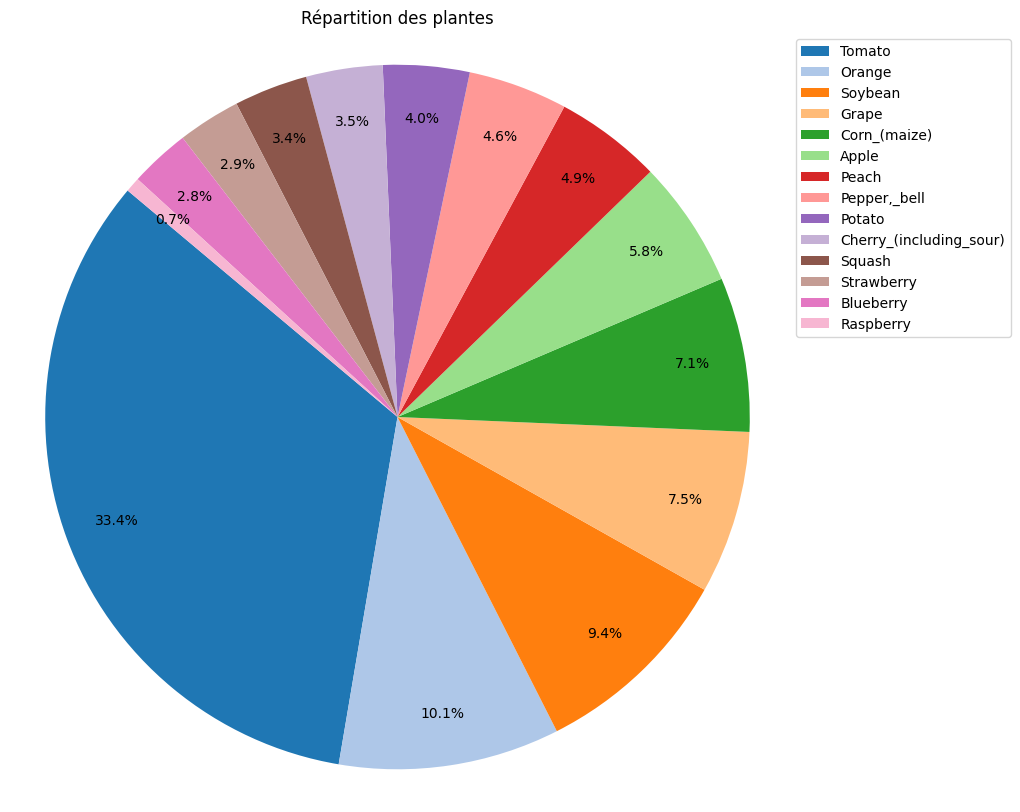

In [14]:
# Graphe en camembert de la répartition des plantes
plante_counts = df['Plante'].value_counts()
colors = plt.cm.tab20.colors

plt.figure(figsize=(10, 10))
plt.pie(plante_counts, labels=['']*len(plante_counts), autopct='%1.1f%%', startangle=140, colors=colors, pctdistance=0.85)
plt.title('Répartition des plantes')
plt.legend(loc='upper right', labels=plante_counts.index, bbox_to_anchor=(1.3, 1))
plt.axis('equal')  
plt.show()

### 2.3 Répartition des maladies par type de plante

Cette analyse montre la proportion de chaque maladie/statut pour chaque type de plante. Les plantes saines sont triées en premier, ce qui permet de voir immédiatement quelles plantes sont principalement en bonne santé et quelles plantes sont principalement affectées par des maladies spécifiques. Cela aide à identifier les priorités pour la modélisation et la détection des maladies.

On note une grande variabilité dans la prévalence des différentes maladies selon le type de plante. Certaines plantes, comme la myrtille, la framboise et le soja sont  entièrement classées comme "saines", tandis que d'autres, comme les oranges et les courges, sont entièrement affectées par une maladie spécifique. Les pommes, le maïs ou bien les tomates présentent une grande diversité de maladies.

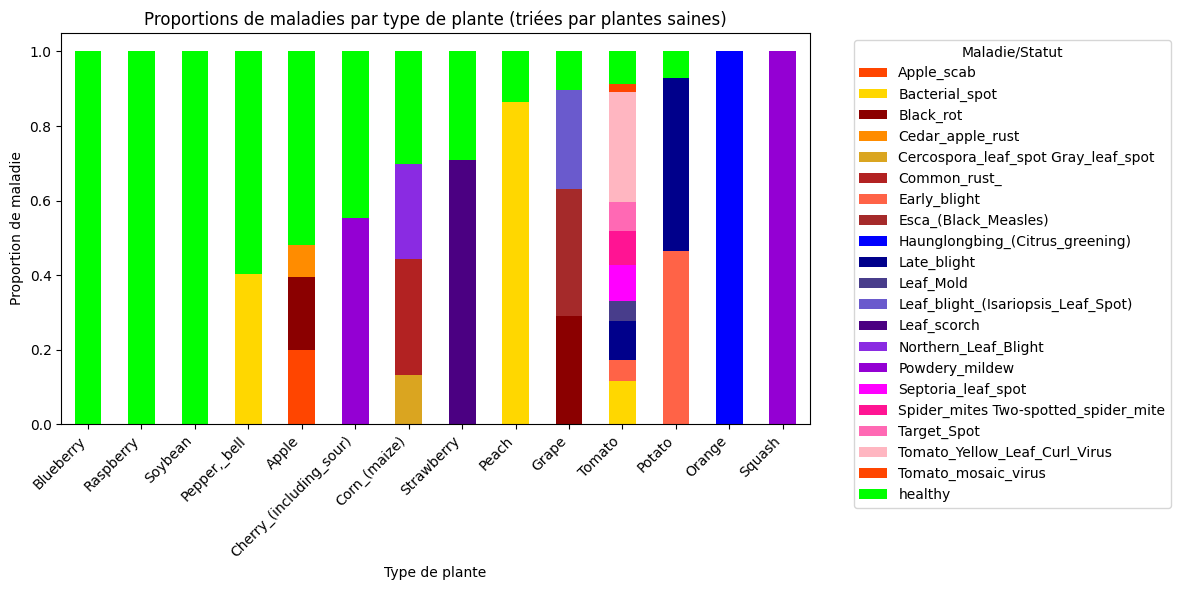

In [15]:
# Proportions de maladies par plante
proportions = df.groupby(['Plante', 'Maladie/Statut']).size().unstack(fill_value=0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

colors = {
    'Apple_scab': '#FF4500', 'Bacterial_spot': '#FFD700', 'Black_rot': '#8B0000', 'Cedar_apple_rust': '#FF8C00',
    'Cercospora_leaf_spot Gray_leaf_spot': '#DAA520', 'Common_rust_': '#B22222', 'Early_blight': '#FF6347',
    'Esca_(Black_Measles)': '#A52A2A', 'Haunglongbing_(Citrus_greening)': '#0000FF', 'Late_blight': '#00008B',
    'Leaf_Mold': '#483D8B', 'Leaf_blight_(Isariopsis_Leaf_Spot)': '#6A5ACD', 'Leaf_scorch': '#4B0082',
    'Northern_Leaf_Blight': '#8A2BE2', 'Powdery_mildew': '#9400D3', 'Septoria_leaf_spot': '#FF00FF',
    'Spider_mites Two-spotted_spider_mite': '#FF1493', 'Target_Spot': '#FF69B4', 'Tomato_Yellow_Leaf_Curl_Virus': '#FFB6C1',
    'Tomato_mosaic_virus': '#FF4500', 'healthy': '#00FF00'
}

sorted_proportions = proportions.sort_values(by='healthy', ascending=False)

sorted_proportions.plot(kind='bar', stacked=True, figsize=(12, 6), color=[colors.get(x, '#333333') for x in sorted_proportions.columns])
plt.title('Proportions de maladies par type de plante (triées par plantes saines)')
plt.xlabel('Type de plante')
plt.ylabel('Proportion de maladie')
plt.legend(title='Maladie/Statut', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2.4 Répartition des maladies 

L'analyse de la distribution des maladies montre que la majorité des images des plantes sont en bonne santé (27.78% classée comme "healthy"). Cependant, plusieurs maladies comme Haunglongbing (Citrus greening), Bacterial spot, et Tomato Yellow Leaf Curl Virus sont relativement fréquentes, affectant environ 10% des plantes chacune.

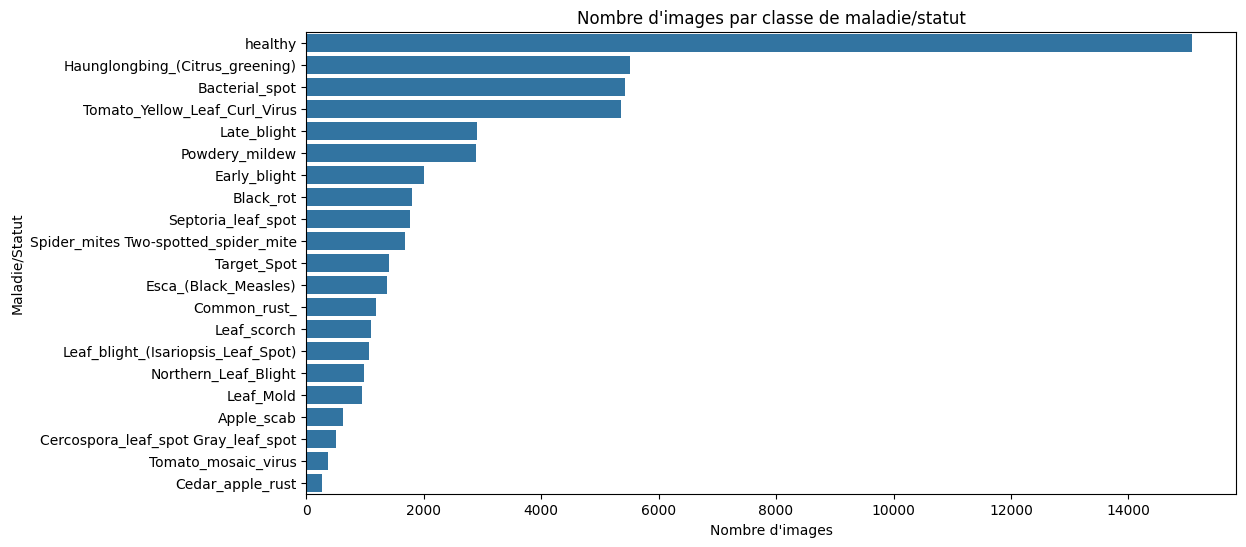

In [14]:
#6 Nombre d'images par maladies
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Maladie/Statut', order=df['Maladie/Statut'].value_counts().index)
plt.title('Nombre d\'images par classe de maladie/statut')
plt.xlabel('Nombre d\'images')
plt.ylabel('Maladie/Statut')
plt.show()

### 2.5 Recherche de doublons d'images

La recherche de doublons dans le jeu de données est essentielle pour s'assurer que le modèle n'est pas biaisé par des images répétées. Les doublons peuvent fausser les résultats de validation et de test.

In [13]:
# 7. Recherche de doublons dans le jeu de données à partir du hash MD5
duplicates = df.groupby('hash').filter(lambda x: len(x) > 1)
duplicates.reset_index(drop=True, inplace=True)

print("Nombre de doublons trouvés :", len(duplicates))
display(duplicates.head(10))
duplicates.info()

Nombre de doublons trouvés : 42


,Chemin,Classe,Nom_image,Largeur,Hauteur,hash,format,mode,Plante,Maladie/Statut
0,D:\aprojet\fev24_cds_plants\data\color\Apple__...,Apple___healthy,11beda66-01e9-4bfd-be37-c0f8646d1478___RS_HL 6...,256,256,dbdc7b5c2c6c935a3bc960a5fdf5ea9c,JPEG,RGB,Apple,healthy
1,D:\aprojet\fev24_cds_plants\data\color\Apple__...,Apple___healthy,13298d36-4425-437d-ae8e-c7d70e200084___RS_HL 6...,256,256,dbdc7b5c2c6c935a3bc960a5fdf5ea9c,JPEG,RGB,Apple,healthy
2,D:\aprojet\fev24_cds_plants\data\color\Apple__...,Apple___healthy,14896dc0-688d-456f-b5ec-a037695b0193___RS_HL 6...,256,256,ee77e60900cd786f301cce876c8adbe7,JPEG,RGB,Apple,healthy
3,D:\aprojet\fev24_cds_plants\data\color\Apple__...,Apple___healthy,1ab5e019-e5f0-4d8e-a252-94cb0aab8b0a___RS_HL 6...,256,256,1e86760b7721d066126b20056e8d5bb2,JPEG,RGB,Apple,healthy
4,D:\aprojet\fev24_cds_plants\data\color\Apple__...,Apple___healthy,3673d121-b5de-481c-b057-d4ee5b4959b1___RS_HL 6...,256,256,1e86760b7721d066126b20056e8d5bb2,JPEG,RGB,Apple,healthy
5,D:\aprojet\fev24_cds_plants\data\color\Apple__...,Apple___healthy,3d075f90-7002-4c45-abc0-4f35ee49aa79___RS_HL 6...,256,256,3bf88aaeb7af8b51f2ac7d031515cf8c,JPEG,RGB,Apple,healthy
6,D:\aprojet\fev24_cds_plants\data\color\Apple__...,Apple___healthy,5192db55-4aa7-421c-92d4-c2dac79e7379___RS_HL 6...,256,256,1987c933d1b47a1ef89727337ffdcc83,JPEG,RGB,Apple,healthy
7,D:\aprojet\fev24_cds_plants\data\color\Apple__...,Apple___healthy,9b75de13-d4b0-4b3f-988c-3e9926eef957___RS_HL 6...,256,256,1987c933d1b47a1ef89727337ffdcc83,JPEG,RGB,Apple,healthy
8,D:\aprojet\fev24_cds_plants\data\color\Apple__...,Apple___healthy,acb21cc2-8d65-4880-a7bb-dcc1eab1564b___RS_HL 6...,256,256,3bf88aaeb7af8b51f2ac7d031515cf8c,JPEG,RGB,Apple,healthy
9,D:\aprojet\fev24_cds_plants\data\color\Apple__...,Apple___healthy,c21cf428-bfc3-4710-b5d2-69d1c0e94748___RS_HL 6...,256,256,ee77e60900cd786f301cce876c8adbe7,JPEG,RGB,Apple,healthy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Chemin          42 non-null     object
 1   Classe          42 non-null     object
 2   Nom_image       42 non-null     object
 3   Largeur         42 non-null     int64 
 4   Hauteur         42 non-null     int64 
 5   hash            42 non-null     object
 6   format          42 non-null     object
 7   mode            42 non-null     object
 8   Plante          42 non-null     object
 9   Maladie/Statut  42 non-null     object
dtypes: int64(2), object(8)
memory usage: 3.4+ KB
